# Logistic Regression Tutorial Pt. 2
<br>
In the second half of the assignment, we will be working with Logistic Regression on another dataset which deals with microchip testing. We are given training data with two features, "Microchip test 1" and "Microchip test 2", and a label column "Accepted" deeming if the chip was accepted based on the two tests. Let's start off with visualizing our data.

     Microchip Test 1  Microchip Test 2  Accepted
0            0.051267          0.699560         1
1           -0.092742          0.684940         1
2           -0.213710          0.692250         1
3           -0.375000          0.502190         1
4           -0.513250          0.465640         1
..                ...               ...       ...
113         -0.720620          0.538740         0
114         -0.593890          0.494880         0
115         -0.484450          0.999270         0
116         -0.006336          0.999270         0
117          0.632650         -0.030612         0

[118 rows x 3 columns]


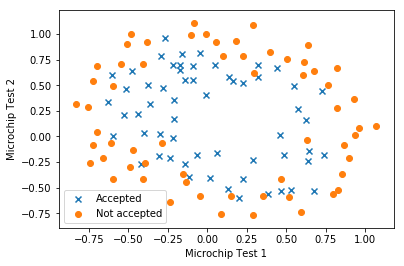

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

pd.set_option('display.max_columns', None)  
pd.options.display.max_rows = 10

df = pd.read_csv('ex2data2.txt', names=["Microchip Test 1", "Microchip Test 2", "Accepted"])
print(df)

accepted = df[df["Accepted"] == 1]
notAccepted = df[df["Accepted"] == 0]

acceptedTest1 = accepted["Microchip Test 1"] # x axis
acceptedTest2 = accepted["Microchip Test 2"] # y axis

notAcceptedTest1 = notAccepted["Microchip Test 1"] # x axis
notAcceptedTest2 = notAccepted["Microchip Test 2"] # y axis

plt.scatter(acceptedTest1, acceptedTest2, marker='x', label="Accepted")
plt.scatter(notAcceptedTest1, notAcceptedTest2, marker='o', label="Not accepted")
plt.legend()
plt.xlabel("Microchip Test 1")
plt.ylabel("Microchip Test 2")
plt.show()

Notice how this dataset's decision boundary cannot be simply represented by a line. We will need to map a more complex polynomial equation to accurately determine this dataset's decision boundary. Thus, we will map the features ($x_1, x_2$) to be polynomial terms up to the sixth-power so that we can come up with this more complex decison boundary:

$$ \begin{equation}
     mapFeatures(x) = mapFeatures(x_1,x_2) =\begin{bmatrix}
         1 \\
         x_1 \\
         x_2 \\
         x_1^2 \\
         x_1x_2 \\
         x_2^2 \\
         ... \\
         x_1x_2^5 \\
         x_2^6
        \end{bmatrix}
  \end{equation} $$
  
This means that for every feature row in the DataFrame, we will transform that row so that it reflects the new polynomial terms described above. That is, we will compute $1, x_1, x_2, x_1^2, x_1x_2, ... , x_1x_2^5, x_2^6$ and that will be a row for our transformed X data. In total there should be still 118 rows but the number of columns increase to 28 since we are adding the new computed terms. We will leverage *sci-kit learn*'s tools to easily come up with our transformed X matrix.

In [2]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=6) 

X_data = df[df.columns[:-1]]
y_data = df[df.columns[-1]]

pd.set_option('display.max_columns', 10)  
transformedX_data = poly.fit_transform(X_data)

print(pd.DataFrame(transformedX_data))

      0         1         2         3         4       ...                 23  \
0    1.0  0.051267  0.699560  0.002628  0.035864      ...       3.380660e-06   
1    1.0 -0.092742  0.684940  0.008601 -0.063523      ...       3.470651e-05   
2    1.0 -0.213710  0.692250  0.045672 -0.147941      ...       9.995978e-04   
3    1.0 -0.375000  0.502190  0.140625 -0.188321      ...       4.987251e-03   
4    1.0 -0.513250  0.465640  0.263426 -0.238990      ...       1.504584e-02   
..   ...       ...       ...       ...       ...      ...                ...   
113  1.0 -0.720620  0.538740  0.519293 -0.388227      ...       7.826790e-02   
114  1.0 -0.593890  0.494880  0.352705 -0.293904      ...       3.046659e-02   
115  1.0 -0.484450  0.999270  0.234692 -0.484096      ...       5.499985e-02   
116  1.0 -0.006336  0.999270  0.000040 -0.006332      ...       1.609667e-09   
117  1.0  0.632650 -0.030612  0.400246 -0.019367      ...       1.501196e-04   

               24            25        

We can check if our transformedX_data matrix makes sense. 
<br>
The 1st column = 1, the 2nd column = $x_1$, the 3rd column = $x_2$, the 4th column = $x_1^2$, the 5th column = $x_1x_2$, ... , the 28th column = $x_2^6$. 
<br><br>
If we take the first row for example, ($x_1 = 0.051267, x_2 = 0.699560$) we can quickly check that: <br><br>
$$x_1x_2 = 0.051267 \times 0.699560 = 0.03586~ ~\text{(5th column (index 4))} \\  
x_2^6 = 0.669560^6 = 1.172060e-01 ~ ~\text{(28th column (index 27))}$$

Now that we have our transformed matrix, we can now move forward with the logistic regression algorithm and fit our theta parameters that will minimize our objective cost function by once again using the gradient and advanced optimization techniques. However this time, the assignment asks for us to incorporate **regularization** into our cost function and gradient calculation. First, let's introduce the concept of **overfitting/underfitting**. 

![](https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/ufrt/kddm/overfitting-logreg-ex.png)

**Overfitting** occurs when the determined model is complex to the point that it fits the training data too well. So although the model fits the training data extrememly well, the model will likely not perform well for new test data since the model caters to the training data too well. **Underfitting** is the opposite, which happens when the model is too simple and cannot fit the data well. In machine learning, we strive to find the balance between overfitting and underfitting data, but in practice this is very hard to do.

One way to reduce overfitting is to incorporate **regularization**. Say we want to make the following expression more linear: $$ \theta_0 + \theta_1x + \theta_2x^2 + \theta_3x^3 + \theta_4x^4$$

Thus we want to reduce the influence of the $\theta_2x^2, \theta_3x^3, \theta_4x^4$ terms. We do this by modifying our cost function (for linear regression) like so:

$$
cost = \frac{1}{2m} \sum_{i = 1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 + 5000\theta_2^2 + 5000\theta_3^3 + 5000\theta_4^4
$$

Since we want to find theta values that will minimize the cost function, $\theta_2, \theta_3, \theta_4$ are going to be very small values since they have been heavily "inflated" by a factor of 5000. Thus we have regularized the equation by reducing the complexity of the expression (by reducing the influence of $\theta_2$) and thus reduced overfitting!

The regularized cost function for logistic regression is generalized using all the $\theta$ terms **except $\theta_0$** through the following equation:

$$
cost = \frac{1}{m} \sum_{i = 1}^m -y^{(i)}\log{}h_\theta(x^{(i)}) - (1-y^{(i)})(1-\log{}h_\theta(x^{(i)})) + \frac{\lambda}{2m}\sum_{j = 1}^m \theta_j^2
$$

Note that $\lambda$ is called the **regularization parameter** and it determines how much to inflate our $\theta$ parameters. Thus, higher $\lambda$ values will reduce overfitting by a bigger measure (perhaps to the point that it will underfit) whereas low $\lambda$ or $\lambda = 0$ means no regularization which entails the possibility of overfitting. Okay time to implement the regularizedCost function for logistic regression!

In [3]:
def sigmoid(x): # same as before
    return 1.0/(1+ math.exp(-x))

def sigmoidMatrix(matrix): # same as before
    for x in np.nditer(matrix, op_flags=['readwrite']):
        x[...]=sigmoid(x)
    return matrix

def regularizedCost(theta,X,y,lamda):
    theta_with_0_as_first = np.insert(theta[1:], 0, 0) 
    # important! don't want to incorporate theta_0 for the regularization term
    # thus substitute theta_0 with 0 and use theta_with_0_as_first for our reg term
    
    theta = np.matrix(theta)
    m = len(y)
    h = sigmoidMatrix(X*theta.T)

    reg_term = lamda*np.sum(np.square(theta_with_0_as_first)) / (2*m)
    
    cost = (-y.T * np.log(h) - (1-y).T * np.log(1-h))/m + reg_term
    return cost[0,0]

To check our work so far, for $\theta$ initialized to all zeros and $\lambda = 1$, regularizedCost should return value around 0.693.

In [4]:
theta = np.zeros(transformedX_data.shape[1])
lamda = 1
y_data = np.asmatrix(y_data).T

print(regularizedCost(theta,transformedX_data, y_data, lamda))

0.69314718056


Great! Again, we are going to be using advanced optimization methods to compute our theta values that gives us the minimum cost. Notice below for the `regularizedGradient(...)` method that we simply just summed the regularization parameter when calculating the gradient. 

In [5]:
def regularizedGradient(theta,X,y,lamda): # vectorized implementation
    theta_with_0_as_first = np.insert(theta[1:],0,0)
    
    theta = np.matrix(theta)
    theta_with_0_as_first = np.matrix(theta_with_0_as_first)
    m = len(y)
    error = sigmoidMatrix(X*theta.T) - y
    
    regTerm = (lamda/m) * theta_with_0_as_first.T
    gradient = (X.T * error) / m + regTerm # added regTerm
    
    return gradient

print("First 6 GRADIENT values: ")
print("with theta = 0, lambda = 1:\n", regularizedGradient(theta,transformedX_data, y_data, lamda)[:6], "\n") 

lamda = 10
theta = np.ones(transformedX_data.shape[1])
print("with theta = 1, lambda = 10:\n", regularizedGradient(theta,transformedX_data, y_data, lamda)[:6])
# theta = 1, lambda = 10

First 6 GRADIENT values: 
with theta = 0, lambda = 1:
 [[  8.47457627e-03]
 [  1.87880932e-02]
 [  7.77711864e-05]
 [  5.03446395e-02]
 [  1.15013308e-02]
 [  3.76648474e-02]] 

with theta = 1, lambda = 10:
 [[ 0.34604507]
 [ 0.16135192]
 [ 0.19479576]
 [ 0.22686278]
 [ 0.09218568]
 [ 0.24438558]]


Seems like all the values line up as indicated in the assignment. Using scipy's optimization methods, we can see the minimum computed cost and the fitted theta values below.

In [6]:
# note that lamda = 10, theta = ones

from scipy.optimize import fmin_tnc
minimum = fmin_tnc(func=regularizedCost, x0=theta, fprime=regularizedGradient, args=(transformedX_data, y_data, lamda))
cost = regularizedCost(minimum[0],transformedX_data,y_data,lamda)
new_theta = np.matrix(minimum[0])

print ("Minimum cost is: " + str(cost) + "\n")
print ("First 6 fitted THETA parameters:\n", new_theta.T[:6])

Minimum cost is: 0.648215701539

First 6 fitted THETA parameters:
 [[ 0.32617755]
 [-0.0081514 ]
 [ 0.16579867]
 [-0.44669159]
 [-0.11178596]
 [-0.2789296 ]]


Finally, we are going to visualize all the hard work we've done so far! Visualization is tricky because the decision boundary is non-linear and our polynomial is pretty sophisticated. The way to do this is to show only one level on a contour plot.

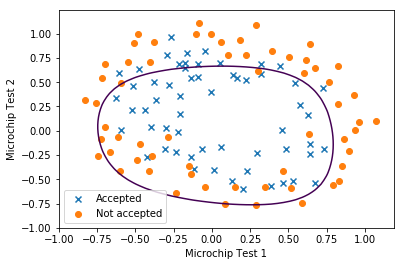

In [7]:
u = np.linspace(-1, 1, 50)
v = np.linspace(-1, 1, 50)

def mapZ(u,v,theta):
    poly = PolynomialFeatures(degree=6)
    z = np.zeros((len(u), len(v)))
    
    for i in range(len(u)):
        for j in range(len(v)):
            fitted = poly.fit_transform([[u[i],v[j]]])
            fitWithTheta = fitted * theta.T
            z[i,j] = fitWithTheta
    return z

z = mapZ(u,v,new_theta) # for lambda = 10

plt.scatter(acceptedTest1, acceptedTest2, marker='x', label="Accepted")
plt.scatter(notAcceptedTest1, notAcceptedTest2, marker='o', label="Not accepted")
plt.legend()
plt.xlabel("Microchip Test 1")
plt.ylabel("Microchip Test 2")
plt.contour(u,v,z,0)
plt.show()

Let's write one final function which will visualize the plot for different regularization parameters. For the following plots, we can really see the relationship between overfitting and regularization.

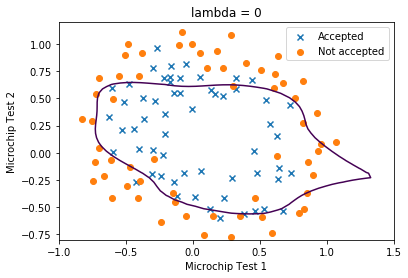

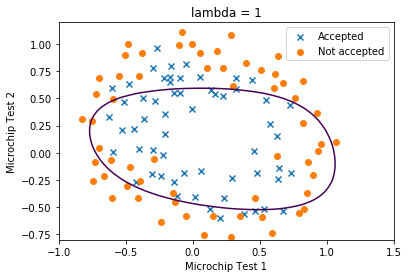

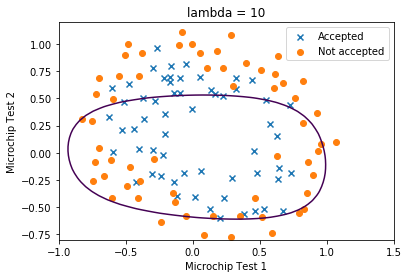

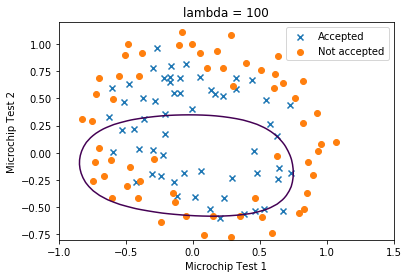

In [8]:
def finalLogRegAndVisualize(X,y,lamda):
    
    poly = PolynomialFeatures(degree=6)
    transformedX_data = poly.fit_transform(X) # mapping features to polynomial degree 6
    
    theta = np.ones(transformedX_data.shape[1]) # doesn't matter if theta is initialized as 0s or 1s
    minimum = fmin_tnc(func=regularizedCost, x0=theta, fprime=regularizedGradient
                       , args=(transformedX_data, y, lamda))
    fitted_theta = np.matrix(minimum[0])
    
    #print(regularizedCost(minimum[0],transformedX_data,y,lamda))
    
    # visualization
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-0.8, 1.2, 50)
    
    z = mapZ(u,v,fitted_theta)
    
    plt.scatter(acceptedTest1, acceptedTest2, marker='x', label="Accepted")
    plt.scatter(notAcceptedTest1, notAcceptedTest2, marker='o', label="Not accepted")
    plt.legend()
    plt.xlabel("Microchip Test 1")
    plt.ylabel("Microchip Test 2")
    plt.contour(u,v,z,0)
    plt.title("lambda = " + str(lamda))
    plt.show()
    
    return 

finalLogRegAndVisualize(X_data, y_data, 0) # overfit 
finalLogRegAndVisualize(X_data, y_data, 1) # normal
finalLogRegAndVisualize(X_data, y_data, 10) # slightly underfit? (you can decide)
finalLogRegAndVisualize(X_data, y_data, 100) # underfit


In [9]:
X_data

,Microchip Test 1,Microchip Test 2
0,0.051267,0.699560
1,-0.092742,0.684940
2,-0.213710,0.692250
3,-0.375000,0.502190
4,-0.513250,0.465640
...,...,...
113,-0.720620,0.538740
114,-0.593890,0.494880
115,-0.484450,0.999270
116,-0.006336,0.999270


In [10]:
X_data = df[df.columns[:-1]]
y_data = df[df.columns[-1]]


In [11]:
X_data

,Microchip Test 1,Microchip Test 2
0,0.051267,0.699560
1,-0.092742,0.684940
2,-0.213710,0.692250
3,-0.375000,0.502190
4,-0.513250,0.465640
...,...,...
113,-0.720620,0.538740
114,-0.593890,0.494880
115,-0.484450,0.999270
116,-0.006336,0.999270


In [12]:
y_data

0      1
1      1
2      1
3      1
4      1
      ..
113    0
114    0
115    0
116    0
117    0
Name: Accepted, Length: 118, dtype: int64